## JupyterLab - homework2.ipynb

                   Left Wheel Velocities (m/s)  Right Wheel Velocities (m/s)  \
Cumulative Δt (s)                                                              
0.0                                       0.00                          0.00   
0.5                                       0.20                          0.20   
1.0                                       0.20                          0.20   
1.5                                       0.25                          0.20   
2.0                                       0.25                          0.20   
2.5                                       0.30                          0.25   
3.0                                       0.30                          0.25   
3.5                                       0.35                          0.35   
4.0                                       0.35                          0.35   
4.5                                       0.50                          0.50   
5.0                                     

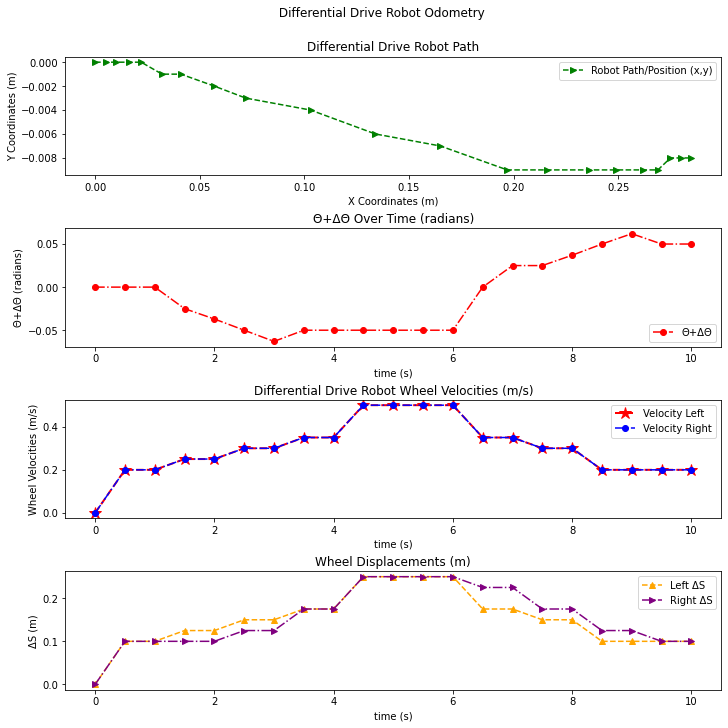


 Please scroll up and down to see entire table. Table includes the velocities of the left and right wheels,
 displacements of left and right wheels, and the position of the differential drive robot.
 Table also includes other useful calculations

 You can also see odometry data in the Odometry Data Calculations.csv file.

 Also visualizations are also saved as a .png file called 'odometry_plots'



In [11]:
# -*- coding: utf-8 -*-
'''
 * File Name: MTRE6100_homework2_main.py
 *
 * Description: Privides odometry data of a differential drive robot.
 *              4 steps:
 *              1. Calculate the velocities of Left and Right wheels of the robot using encoder angular velocities data
 *              2. Calculate the displacement of Left and Right wheels of the robot using the calculated velocities
 *              3. Calculate the orientation (angle) of the robot based on wheel displacements
 *              4. Calculate the robot's position relative to the origin of P0 = (0,0,0)
 * Author: Destany Brown
 *
 * Create Date: 2021-9-10
 *
 * Version: 1.0 
 *
'''


import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

# ω
omega_l = [2, 2, 2.5, 2.5, 3, 3, 3.5, 3.5, 5, 5, 5, 5, 3.5, 3.5, 3, 3,
           2, 2, 2, 2]  # angular velocity (rad/s) out put of left wheel encoder
omega_r = [2, 2, 2, 2, 2.5, 2.5, 3.5, 3.5, 5, 5, 5, 5, 4.5, 4.5, 3.5, 3.5,
           2.5, 2.5, 2, 2]  # angular velocity (rad/s) out put of right wheel encoder

L = 0.5  # meters
robot_width = 2*L  # robot's width in meters
wheel_radius = 0.1  # robot wheels' radi meters
delta_time = 0.5  # seconds

init_pos = (0, 0, 0)  # robot's initial coordinates (position)


class differential_drive_robot():

    def __init__(self, omegaL, omegaR, robotW, wheelRad, initPos, deltaTime):
        '''
        the initialization of the object
        '''
        # left and right wheel velocity given robot wheels' radi and angular velocity m/s
        # left and right wheel displacements
        self.odometry_data = self.odometry(omegaL, omegaR, robotW, wheelRad, deltaTime)

    # returns wheel velocities velocity = wheel radius * angular velocity from encoders
    def odometry(self, omegaL, omegaR, robW, wheelR, dTime):
        '''
        * Description: calculate odometry of the differential drive robot:
        *        With left and right wheel encoder angular velocity readings
        *        With enocder sampling times
        *        With wheel and robot body dimensions
        * input: omegaL, encoder readings of the left wheel angular velocities (rad/s)
        *        omegaR, encoder readings of the right wheel angular velocities (rad/s)
        *        robW, the width of the robot body (m)
        *        wheelR, radius of the left and right wheel (m)
        *        dTime, sampling time of encoder readings (s) 
        * ouput: df, a pandas DataFrame with:
        *        sum_time, Cumulative Δt (s)
        *        velocity_l, Left Wheel Velocities (m/s)
        *        velocity_r, Right Wheel Velocities (m/s)
        *        displacement_l, Left ΔS (m)
        *        displacement_r, Right ΔS (m)
        *        positions, Position (x,y,Θ)
        *        coord_x, X Coordinates (m)
        *        coord_y, Y Coordinates (m)
        *        delta_theta_cumsum, ΔΘ Cumulative Sum (radians)
        *        delta_theta_lis, ΔΘ (radians)
        *        sampling_time, Δt (s)
        *        deltaS, ΔS (m)
        *        cum_dips, Cumulative ΔS (m)
        *        np.cumsum(displacement_l).tolist(), Cumulative Left ΔS (m)
        *        np.cumsum(displacement_r).tolist(), Cumulative Right ΔS (m)
        *        delta_x, ΔX (m)
        *        delta_y, ΔY (m)
        '''
        velocity_l = [0]
        velocity_r = [0]
        sampling_time = [0]
        displacement_l = [0]
        displacement_r = [0]
        overall_displacement = [0]
        delta_x = [0]
        delta_y = [0]
        current_theta = 0
        delta_theta_list = [0]
        deltaS = [0]
        positions = []
        for i in range(len(omegaL)):
            # calculating displacement and velocity of left wheel
            velL = omegaL[i]*wheelR
            velocity_l.append(velL)
            dispL = velL*dTime
            displacement_l.append(dispL)

            # calculating displacement and velocity of right wheel
            velR = omegaR[i]*wheelR
            velocity_r.append(velR)
            dispR = velR*dTime
            displacement_r.append(velR*dTime)

            # calculating total displacement of the robot
            deltaDisp = (dispL*dispR)/2
            deltaS.append(deltaDisp)

            # calculating the change in theta
            deltaTheta = (dispR-dispL)/robW
            
            tot_theta = current_theta+(deltaTheta/2)
            delta_theta_list.append(current_theta+deltaTheta)
            
            current_theta = tot_theta
            # calculating x and y coordinates
            delta_x.append(deltaDisp * math.cos(tot_theta))
            delta_y.append(deltaDisp*math.sin(tot_theta))
            
            sampling_time.append(dTime)

        # cumulative sum of time
        sum_time = np.cumsum(sampling_time).tolist()

        # cumulative sum of delta_x
        coord_x = np.cumsum(delta_x).tolist()
        # cumulative sum of delta_y
        coord_y = np.cumsum(delta_y).tolist()

        # cumulative sum of delta_theta_list
        #delta_theta_cumsum = np.cumsum(delta_theta_list).tolist()
        for i in range(len(coord_x)):
            positions.append((round(coord_x[i], 3), round(
                coord_y[i], 3), round(delta_theta_list[i], 3)))
        # cumulative displacement
        cum_disp = np.cumsum(deltaS).tolist()
        
        #stores odometry calculations in a dictionary object called data
        data = {"Cumulative Δt (s)": sum_time, "Left Wheel Velocities (m/s)": velocity_l, "Right Wheel Velocities (m/s)": velocity_r,
                "Left ΔS (m)": displacement_l, "Right ΔS (m)": displacement_r,
                "X Coordinates (m)": coord_x, "Y Coordinates (m)": coord_y,
                "Θ+ΔΘ (radians)": delta_theta_list,
                "ΔS (m)": deltaS, "Cumulative ΔS (m)": cum_disp,
                "Cumulative Left ΔS (m)": np.cumsum(displacement_l).tolist(),
                "Cumulative Right ΔS (m)": np.cumsum(displacement_r).tolist(),
                "ΔX (m)": delta_x, "ΔY (m)": delta_y}
        
        #rounds data within dictionary to 3 decimal points and stores it into a new variable called data_rounded
        data_rounded = {key: [round(i, 3) for i in data[key]] for key in data}
        
        #updates data_rounded with new data called positions (x,y,Θ+ΔΘ)
        data_rounded["Position (x,y,Θ+ΔΘ)"] = positions
        
        #creates a pandas DataFrame called df using the dictionary data_rounded
        df = pd.DataFrame(data_rounded)
        df = df.reindex(columns=["Cumulative Δt (s)", 'Left Wheel Velocities (m/s)',
                                 'Right Wheel Velocities (m/s)', 'Left ΔS (m)', 'Right ΔS (m)', "Position (x,y,Θ+ΔΘ)",
                                 'X Coordinates (m)', 'Y Coordinates (m)', 'Θ+ΔΘ (radians)',
                                 'ΔS (m)', 'Cumulative ΔS (m)', 'Cumulative Left ΔS (m)',
                                 'Cumulative Right ΔS (m)', 'ΔX (m)', 'ΔY (m)'])
        df = df.set_index("Cumulative Δt (s)")
        
        #saves df, the pandas DataFrame, as a .csv called Odometry Data Calculations 
        df.to_csv("Odometry Data Calculations.csv")
        return df

    def robot_plots(self):
        
        '''
        * Description: odometry_data visualizations
        *        
        * input: self.odometry_data
        *
        * output: Robot Path/Positions (x,y)
        *         ΔΘ Over Time (radians)
        *         Differential Drive Robot Wheel Velocities (m/s)
        *         Wheel Displacements (m)
        '''
            
        #object odometry_data attribute data
        o_df = self.odometry_data.reset_index()
        
        #subplot configuration
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(
            4, constrained_layout=True, figsize=(10, 10))
        #figure title
        fig.suptitle("         Differential Drive Robot Odometry\n")
        
        #line plot of the x and y position of the robot object
        l1, = ax1.plot(o_df["X Coordinates (m)"], o_df["Y Coordinates (m)"],
                       '>--', c="g", label="Robot Path/Position (x,y)")
        ax1.legend(loc="upper right")
        ax1.set_title("Differential Drive Robot Path")
        ax1.set_xlabel("X Coordinates (m)")
        ax1.set_ylabel("Y Coordinates (m)")
        
        #line plot of the change in the robot objects orientation over time
        l2, = ax2.plot(o_df["Cumulative Δt (s)"],
                       o_df["Θ+ΔΘ (radians)"], "o-.", c="red", label="Θ+ΔΘ")
        ax2.set_title("Θ+ΔΘ Over Time (radians)")
        ax2.set_ylabel("Θ+ΔΘ (radians)")
        ax2.set_xlabel("time (s)")
        ax2.legend(loc="lower right")
        
        #line plot of the left and right wheel velocities over time
        ax3.plot(o_df["Cumulative Δt (s)"], o_df["Left Wheel Velocities (m/s)"],
                 "*--", c="red", linewidth=2, markersize=12, label="Velocity Left")
        ax3.set_title("Differential Drive Robot Wheel Velocities (m/s)")
        l3, = ax3.plot(o_df["Cumulative Δt (s)"], o_df["Left Wheel Velocities (m/s)"],
                       "o-.", c="blue", label="Velocity Right")
        ax3.set_ylabel("Wheel Velocities (m/s)")
        ax3.set_xlabel("time (s)")
        ax3.legend(loc="upper right")
        
        #line plot of the left and right wheel displacements over time
        l4, = ax4.plot(o_df["Cumulative Δt (s)"],
                       o_df["Left ΔS (m)"], "^--", c="orange", label="Left ΔS")
        ax4.set_title("Wheel Displacements (m)")
        l5, = ax4.plot(o_df["Cumulative Δt (s)"],
                       o_df["Right ΔS (m)"], ">-.", c="purple", label="Right ΔS")
        ax4.set_ylabel("ΔS (m)")
        ax4.set_xlabel("time (s)")
        ax4.legend(loc="upper right")
        
        #saves figure of plots to a .png called odometry_plots
        fig.savefig('odometry_plots.png')
        plt.show()


if __name__ == '__main__':
    '''main'''
    #creates robot object from the class differential_drive_robot
    mobile_robot = differential_drive_robot(omega_l, omega_r, robot_width, wheel_radius, init_pos, delta_time)
    
#calls the attribute, odometry_data, of differenital_drive_robot object, mobile_robot, and stores it in a pandas DataFrame called mobile_robot_df
mobile_robot_df = mobile_robot.odometry_data

# more options can be specified also
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #prints out entire mobile_robot_df (pandas DataFrame) table
    print(mobile_robot_df)

#calls the method, robot_plots, of the mobile_robot object of differenital_drive_robot object, mobile_robot, and displays odometry visualization plots of mobile_robot
mobile_robot.robot_plots()

print("\n Please scroll up and down to see entire table. Table includes the velocities of the left and right wheels,\n displacements of left and right wheels, and the position of the differential drive robot.\n Table also includes other useful calculations")
print("\n You can also see odometry data in the Odometry Data Calculations.csv file.")
print("\n Also visualizations are also saved as a .png file called 'odometry_plots'\n")

In [12]:
mobile_robot_df

,Left Wheel Velocities (m/s),Right Wheel Velocities (m/s),Left ΔS (m),Right ΔS (m),"Position (x,y,Θ)",X Coordinates (m),Y Coordinates (m),Θ+ΔΘ (radians),ΔS (m),Cumulative ΔS (m),Cumulative Left ΔS (m),Cumulative Right ΔS (m),ΔX (m),ΔY (m)
Cumulative Δt (s),,,,,,,,,,,,,,
0.0,0.00,0.00,0.000,0.000,"(0.0, 0.0, 0)",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.5,0.20,0.20,0.100,0.100,"(0.005, 0.0, 0.0)",0.005,0.000,0.000,0.005,0.005,0.100,0.100,0.005,0.000
1.0,0.20,0.20,0.100,0.100,"(0.01, 0.0, 0.0)",0.010,0.000,0.000,0.005,0.010,0.200,0.200,0.005,0.000
1.5,0.25,0.20,0.125,0.100,"(0.016, -0.0, -0.025)",0.016,-0.000,-0.025,0.006,0.016,0.325,0.300,0.006,-0.000
2.0,0.25,0.20,0.125,0.100,"(0.022, -0.0, -0.037)",0.022,-0.000,-0.037,0.006,0.022,0.450,0.400,0.006,-0.000
2.5,0.30,0.25,0.150,0.125,"(0.032, -0.001, -0.05)",0.032,-0.001,-0.050,0.009,0.032,0.600,0.525,0.009,-0.000
3.0,0.30,0.25,0.150,0.125,"(0.041, -0.001, -0.063)",0.041,-0.001,-0.063,0.009,0.041,0.750,0.650,0.009,-0.000
3.5,0.35,0.35,0.175,0.175,"(0.057, -0.002, -0.05)",0.057,-0.002,-0.050,0.015,0.057,0.925,0.825,0.015,-0.001
4.0,0.35,0.35,0.175,0.175,"(0.072, -0.003, -0.05)",0.072,-0.003,-0.050,0.015,0.072,1.100,1.000,0.015,-0.001
